In [6]:
!pip install torch
!pip install seaborn


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/7b/e5/83fcd7e9db036c179e0352bfcd20f81d728197a16f883e7b90307a88e65e/seaborn-0.13.0-py3-none-any.whl.metadata
  Using cached seaborn-0.13.0-py3-none-any.whl.metadata (5.3 kB)
Using cached seaborn-0.13.0-py3-none-any.whl (294 kB)

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [14]:
# Load helpers and custom dataset class
from __init__ import PricingWizardDataset, base_regression_pipeline, regression_accuracy, load_model

# Data manipulation 
import pandas as pd
import numpy as np
import os
import time
import math
import zipfile

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score

In [2]:
# Load Data
data = PricingWizardDataset()

Dataset Loaded: post_preprocessing_without_dummies
	Number of Rows: 283055
	Number of Columns: 22
	Outlier Removal: True
	Train Size: 0.8
	Test Size: 0.2
	Random State: 42


In [3]:
# Apply data preparation
print('Applying data preparation...')
data.apply_function(base_regression_pipeline)
print('Done.')

Applying data preparation...
Done.


In [4]:
# Split data
data.stratify_train_test_split(y_column='log_listing_price',
                               val_size=0,
                               return_splits=False)

Dependent variable distribution is equal across all subsets


# Random Forest

In [17]:
# Current working directory
cwd = os.getcwd()

# model directory
model_dir = os.path.join(cwd, 'models', 'pickled_models')

with zipfile.ZipFile(f'{model_dir}/prediction_random_forest.pkl.zip', 'r') as zip_ref:
    # Extract all contents to the specified directory
    zip_ref.extractall(model_dir)

random_forest = load_model(f'{model_dir}/base_regression.pkl')

Model loaded successfully from /Users/albertobfilho/Repositories/data-mining/pricing_wizards/models/pickled_models/base_regression.pkl


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator LinearRegression from version 1.2.2 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [30]:
# Evaluate the model using cross-validation and calculates the mean
cv_scores: list = cross_val_score(random_forest, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
mse_mean_cv_linear: float = -np.mean(cv_scores)

# Train the final model on the entire training set, measuring the training time in seconds
start_time = time.time()
random_forest.fit(X_train, y_train)
end_time = time.time()

# Calculate training time
training_time = end_time - start_time

# Evaluate the final model on the test set
y_pred_test = random_forest.predict(X_test)

regression_accuracy(y_pred_test, y_test)
print("Cross-validation Score:", mse_mean_cv_linear)
print("Training Time:", training_time_linear)

R2 Score: 0.545688524120013
MSE: 0.4377192037318848
MAE 0.5132591419885848
RMSE 0.6616035094615844
Cross-validation Score: 0.44071622353724804
Training Time: 0.02845907211303711


In [23]:
# Calculate permutation importances for the regressor to have a similar metric between the models
feature_importances_values = permutation_importance(random_forest, X_test, y_test, n_repeats=10, random_state=42).importances_mean
feature_importance = pd.DataFrame({'Feature': X_val.columns, 'Importance': feature_importances_values})
feature_importance.sort_values(by='Importance', ascending=False)

,Feature,Importance
1,brand_name,0.631048
3,subsubsubcategory_name,0.128687
2,condition_name,0.055601
0,classified_id,0.000521


In [22]:
# Feature importance based on regressor coefficients
model_coef = random_forest.coef_
feature_importance = pd.DataFrame({'Feature': X_val.columns, 'Coef': model_coef})
feature_importance.sort_values(by='Coef', ascending=False)

,Feature,Coef
1,brand_name,8.211942e-01
3,subsubsubcategory_name,4.991623e-01
2,condition_name,1.519293e-01
0,classified_id,3.315225e-08


# Visualizations

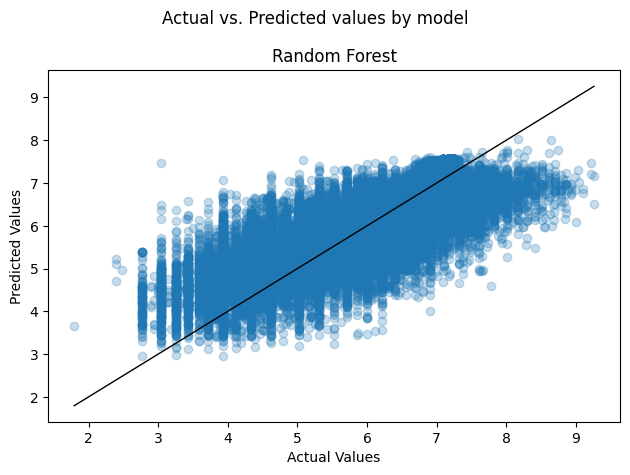

In [33]:
# actual vs predicted
models = [random_forest]
labels= ["Random Forest"]

fig, ax = plt.subplots(tight_layout=True)

for i, model in enumerate(models):
    ax.scatter(y_test, y_pred_test, alpha=0.25)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k', lw=1)
    ax.set_title(labels[i])
    ax.set_xlabel('Actual Values')
    ax.set_ylabel('Predicted Values')

plt.suptitle("Actual vs. Predicted values by model")

plt.show(fig)

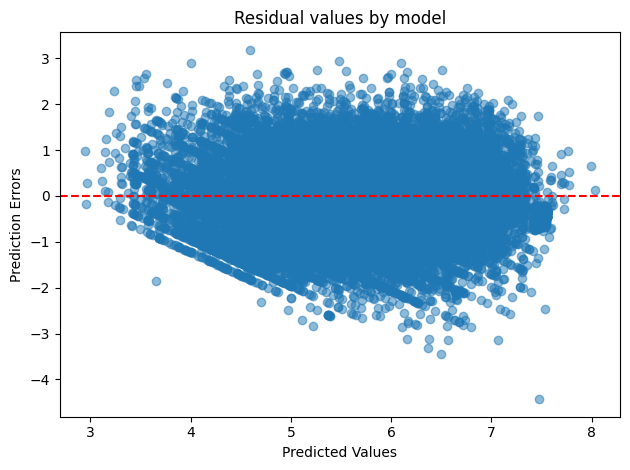

In [28]:
# residuals
models = [random_forest]
labels = ["Random Forest"]

# Use a single figure for all models
fig, ax = plt.subplots(tight_layout=True)

for i, model in enumerate(models):
    # Calculate residuals
    prediction_error = y_test - model.predict(X_test)

    # Plot the scatter plot on the same figure
    ax.scatter(model.predict(X_test), prediction_error, alpha=0.5)
    ax.axhline(y=0, color='r', linestyle='--')
    ax.set_title(labels[i])
    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('Prediction Errors')

plt.title("Residual values by model")
plt.show()